# Customer Sentiment Analysis on Amazon Reviews (NLP + Machine Learning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
np.random.seed(42)

In [2]:
df = pd.read_csv("C:\\Users\\Prathmesh Aphale\\Downloads\\amazon.csv")
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


In [4]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nDescribe (numeric):")
df.describe()

Shape: (4915, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   int64  
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(2), int64(7), object(3)
memory usage: 460.9+ KB
None

Describe (numeric):


,Unnamed: 0,overall,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
count,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000
mean,2457.000000,4.587589,437.367040,1.311089,0.210376,1.521465,1.100712,0.075468,0.020053
std,1418.982617,0.996845,209.439871,41.619161,4.023296,44.123095,39.367949,0.256062,0.077187
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-130.000000,0.000000,0.000000
25%,1228.500000,5.000000,281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2457.000000,5.000000,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3685.500000,5.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4914.000000,5.000000,1064.000000,1952.000000,183.000000,2020.000000,1884.000000,1.000000,0.957544


In [20]:
print("Missing values per column:\n")
print(df.isnull().sum())

data = df.copy()
data = data.dropna(subset=["overall", "reviewText"])

# Ensuring rating is integer
data["overall"] = data["overall"].astype(int)

print("\nAfter cleaning shape:", data.shape)
print("\nMissing values after cleaning:\n")
print(data.isnull().sum())

Missing values per column:

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

After cleaning shape: (4914, 12)

Missing values after cleaning:

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


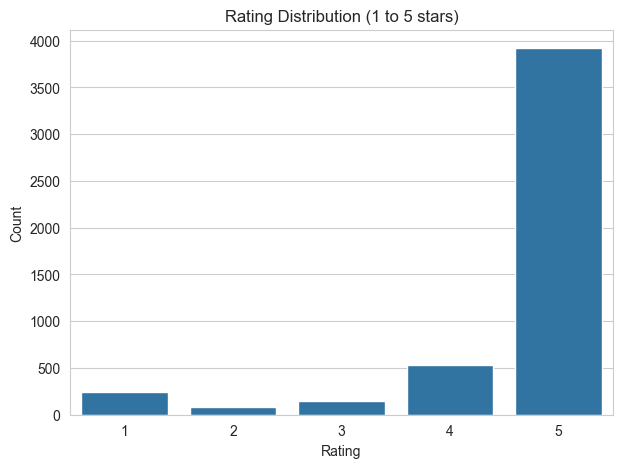

Rating proportions:
overall
5    0.797924
4    0.107245
1    0.049654
3    0.028897
2    0.016280
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(7,5))
sns.countplot(x=data["overall"])
plt.title("Rating Distribution (1 to 5 stars)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

print("Rating proportions:")
print(data["overall"].value_counts(normalize=True))

The rating distribution shows that most customers gave the product five stars. Nearly four out of five reviews are in the highest rating. Very few people gave three stars or below. Only a small number of customers left one or two star reviews. Overall, the data shows that customer opinion is strongly positive, but the ratings are not balanced across categories, which is important to remember when building a sentiment model.

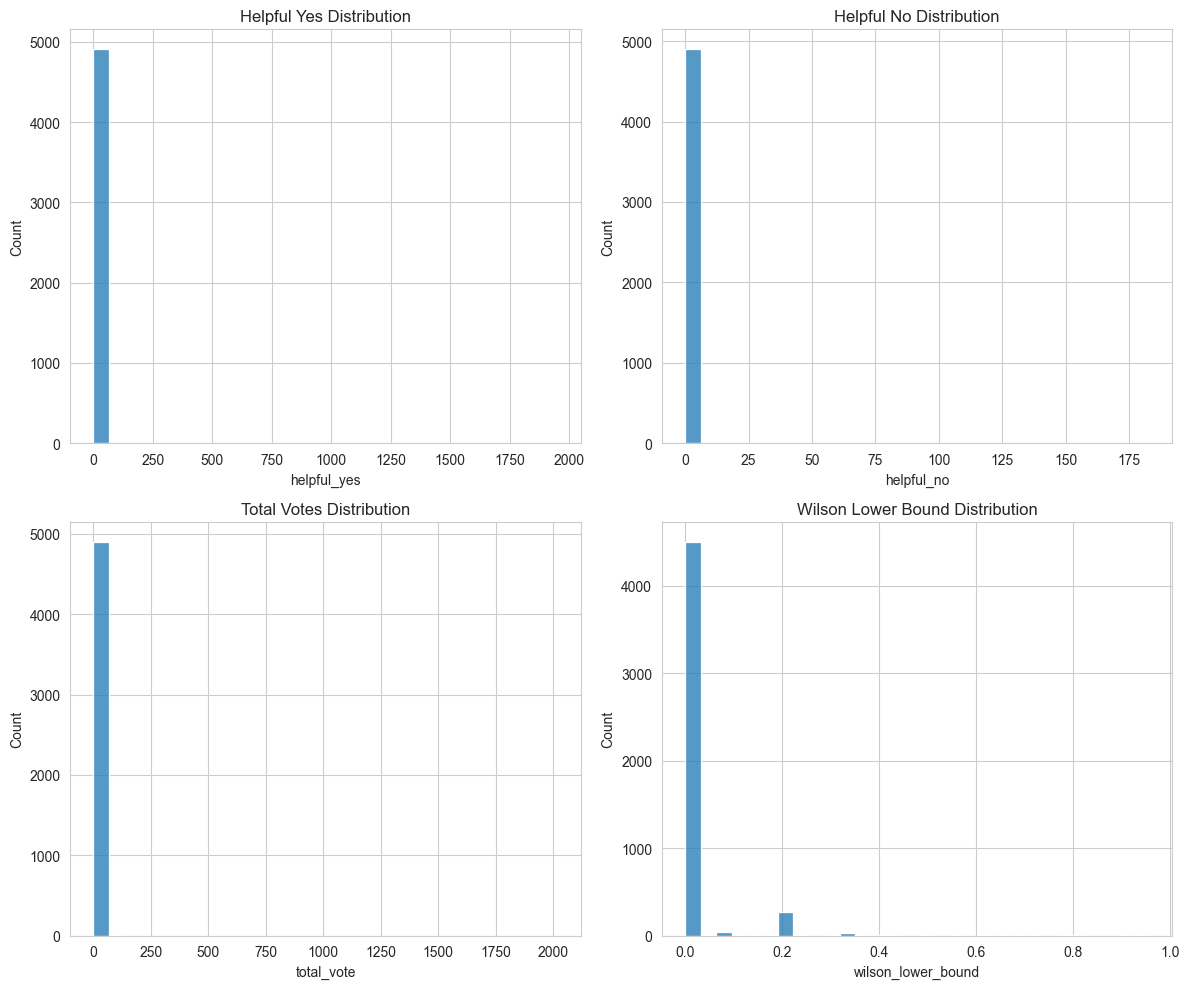

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

sns.histplot(data["helpful_yes"], bins=30, ax=axes[0,0])
axes[0,0].set_title("Helpful Yes Distribution")

sns.histplot(data["helpful_no"], bins=30, ax=axes[0,1])
axes[0,1].set_title("Helpful No Distribution")

sns.histplot(data["total_vote"], bins=30, ax=axes[1,0])
axes[1,0].set_title("Total Votes Distribution")

sns.histplot(data["wilson_lower_bound"], bins=30, ax=axes[1,1])
axes[1,1].set_title("Wilson Lower Bound Distribution")

plt.tight_layout()
plt.show()

Most reviews received almost no helpful votes, which is why the bars are tightly packed near zero in all four charts. Helpful yes, helpful no, and total vote counts are very low for almost every review, showing that users rarely interact with the helpfulness feature. The Wilson lower bound scores also sit near zero for most rows, because the score depends on the number of helpful votes. Only a few reviews gained enough attention to stand out. Overall, the data shows that helpfulness feedback is very limited, so it should be used with care in any analysis.

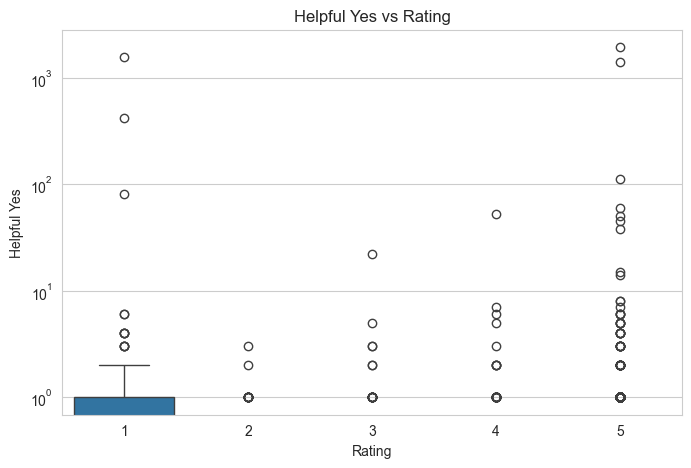

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(x="overall", y="helpful_yes", data=data)
plt.title("Helpful Yes vs Rating")
plt.xlabel("Rating")
plt.ylabel("Helpful Yes")
plt.yscale("log") 
plt.show()

Helpful yes votes are low across all rating groups, but a few reviews stand out with very high helpfulness. These outliers appear mostly in the one star and five star categories, which suggests that users tend to mark only very strong opinions as useful. Most reviews, regardless of rating, receive almost no helpful feedback. The overall pattern shows that helpfulness does not rise smoothly with rating and is driven mainly by a small number of highly visible reviews.

In [9]:
def map_sentiment(r):
    if r >= 4:
        return "Positive"
    elif r == 3:
        return "Neutral"
    else:
        return "Negative"

data["Sentiment"] = data["overall"].apply(map_sentiment)

print(data["Sentiment"].value_counts())

Sentiment
Positive    4448
Negative     324
Neutral      142
Name: count, dtype: int64


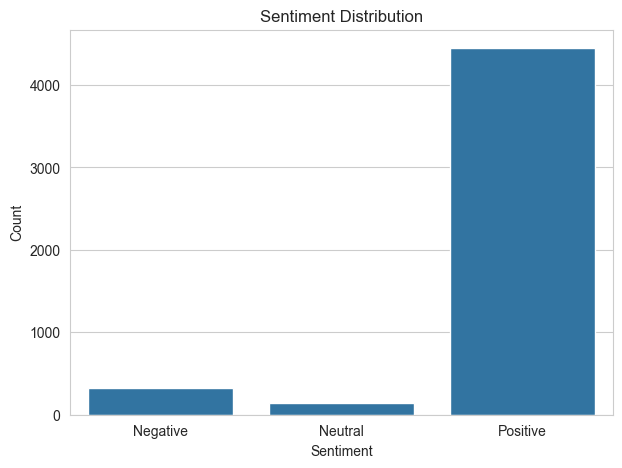

In [10]:
plt.figure(figsize=(7,5))
sns.countplot(x=data["Sentiment"], order=["Negative", "Neutral", "Positive"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

The sentiment distribution shows that most reviews fall into the positive category, which matches the earlier rating pattern. Neutral and negative reviews make up a much smaller portion of the data. This strong tilt toward positive sentiment means the dataset is not balanced, and the model will see far more positive examples during training. It also suggests that customers generally had a very good experience with the product.

In [11]:
stopword_set = set(stopwords.words("english"))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-zA-Z ]", " ", text)  # keep letters and spaces
    tokens = [w for w in text.split() if w not in stopword_set]
    return " ".join(tokens)

data["cleaned"] = data["reviewText"].apply(clean_text)

data[["reviewText", "cleaned"]].head()

,reviewText,cleaned
0,No issues.,issues
1,"Purchased this for my device, it worked as adv...",purchased device worked advertised never much ...
2,it works as expected. I should have sprung for...,works expected sprung higher capacity think ma...
3,This think has worked out great.Had a diff. br...,think worked great diff bran gb card went sout...
4,"Bought it with Retail Packaging, arrived legit...",bought retail packaging arrived legit orange e...


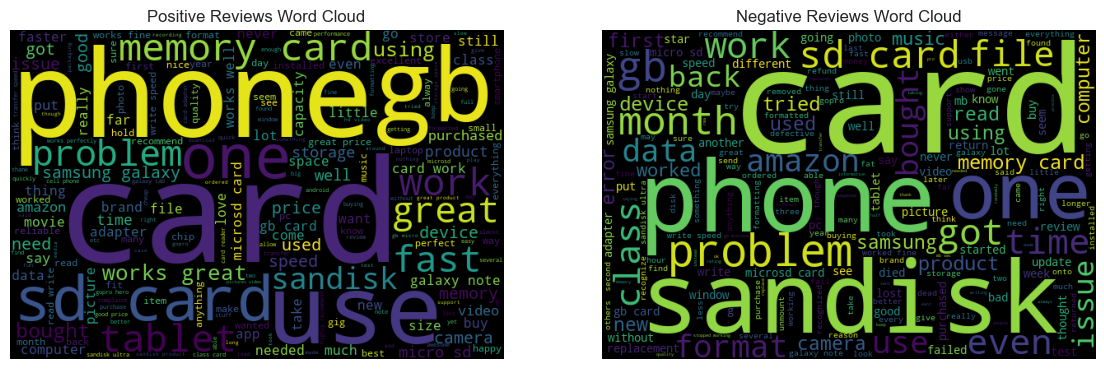

In [12]:
positive_text = " ".join(data[data["Sentiment"] == "Positive"]["cleaned"])
negative_text = " ".join(data[data["Sentiment"] == "Negative"]["cleaned"])

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title("Positive Reviews Word Cloud")
wc_pos = WordCloud(width=600, height=400).generate(positive_text)
plt.imshow(wc_pos)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Negative Reviews Word Cloud")
wc_neg = WordCloud(width=600, height=400).generate(negative_text)
plt.imshow(wc_neg)
plt.axis("off")

plt.show()

The word clouds show clear patterns in how customers talk about the product. Positive reviews focus on words related to smooth use and good performance, with terms like phone, card, memory, and works appearing often. These words suggest that satisfied users mainly talk about reliability and ease of use. In negative reviews, words like card, problem, file, and time appear more, which points to issues with data handling, defects, or failures over time. Both sets share some common product terms, but the tone changes based on the problems or praises described.

In [13]:
X = data["cleaned"]
y = data["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("\nTrain sentiment distribution:")
print(y_train.value_counts(normalize=True))

Train size: 3931
Test size: 983

Train sentiment distribution:
Sentiment
Positive    0.905113
Negative    0.065887
Neutral     0.029000
Name: proportion, dtype: float64


In [14]:
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((3931, 5000), (983, 5000))

In [15]:
model = LogisticRegression(max_iter=300)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


In [16]:
y_pred = model.predict(X_test_tfidf)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.82      0.28      0.41        65
     Neutral       0.00      0.00      0.00        28
    Positive       0.93      1.00      0.96       890

    accuracy                           0.92       983
   macro avg       0.58      0.43      0.46       983
weighted avg       0.89      0.92      0.90       983



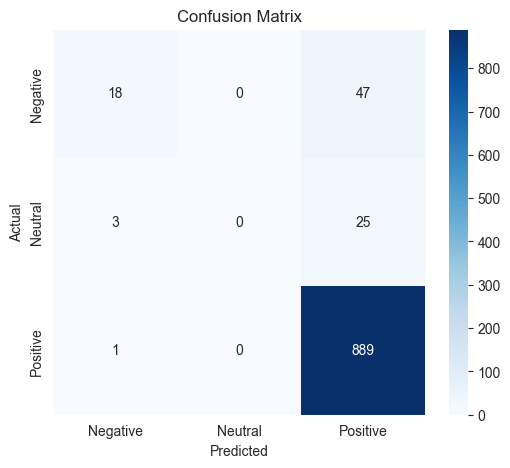

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=["Negative", "Neutral", "Positive"])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

This confusion matrix makes the model’s behavior very clear. Most predictions fall into the positive class, and the model handles positive reviews with high accuracy. Negative and neutral reviews are harder for the model, and many of them are misclassified as positive. This happens because the dataset is heavily skewed toward positive sentiment, so the model has far fewer examples of the other classes to learn from. Even though the overall accuracy looks high, the matrix shows that performance on minority classes is limited, which is important when evaluating the model’s real usefulness.

In [18]:
results = pd.DataFrame({
    "reviewText": X_test,
    "Actual": y_test,
    "Predicted": y_pred
}).sample(10, random_state=42)

pd.set_option("display.max_colwidth", 200)
results

,reviewText,Actual,Predicted
5,mini storage anything else supposed purchased add additional storage microsoft surface pro tablet come gb supposed sandisk long standing reputation speaks,Positive,Positive
1050,never problem sandisk products make sure camera device actually use gb limited gb,Positive,Positive
1498,card awesome even seems make phone run faster would say must,Positive,Positive
3657,bought surface rt works fine also got even better,Positive,Positive
2841,card seems fast huge amount storage price worked flawlessly months range smartphones cameras,Positive,Positive
3566,favor pay extra money card seriously spend money nice phone like using capability get memory card enjoy phone supposed run,Positive,Positive
797,works issues far also able purchase much less wal mart,Positive,Positive
3102,card met requirements wanted gb card adapter wanted faster card c worked box problem bought time one mine one wife smartphone samsung galaxy centura satisfied,Positive,Positive
4635,easy use thought necessary plenty storage movies use microsoft surface pro,Positive,Positive
650,realistically probably could gotten away gb card like anything better need need popped moblie phone put music plus enough room photos videos etc hiccups errors yet holds ton stuff,Positive,Positive


These sample predictions show that the model handles positive reviews well. The text in these examples uses words linked to smooth performance, good quality, and problem free use, and the model identifies this pattern correctly. Since the dataset contains many more positive reviews than negative or neutral ones, the model becomes very confident in predicting the positive class. This small table confirms that the model is strong when the review tone is clearly supportive, but it also reminds us that performance on the other classes needs more attention.

In [19]:
import joblib

joblib.dump(model, "amazon_sentiment_model.pkl")
joblib.dump(tfidf, "amazon_tfidf_vectorizer.pkl")

print("Model and vectorizer saved.")

Model and vectorizer saved.


This project gave a clear view of how customers feel about the product by combining data exploration, text cleaning, sentiment labeling, and machine learning. The analysis showed that most reviews were strongly positive, and the model learned these patterns well. Even with the imbalance in the dataset, the classifier produced reliable results for the dominant sentiment and helped highlight the key themes in both positive and negative feedback. Overall, the project worked smoothly end to end and delivered useful insights, making it a successful example of practical sentiment analysis.